# Load Required Libraries

In [1]:
library(dplyr)
library(ggplot2)
library(wesanderson)
library(reshape2)
library(matrixStats)
options(repr.plot.width=16, repr.plot.height=8)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘reshape2’ was built under R version 4.0.5”

Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




## Import Module to Genes data

In [2]:
module_genes <- read.csv("Network_Analysis/module_genes_binary7_BS18000.csv", header = TRUE)[c("colors", "genes")]
rownames(module_genes) <- module_genes$colors

In [3]:
df <- c()
for (i in 1:nrow(module_genes)){
    genes_list = unlist(strsplit(module_genes[i,2], ", "))
    gene_df = data.frame(Genes = genes_list, Colors = module_genes[i,1])
    df <- rbind(df, gene_df)
}

head(df)
dim(df)
length(unique(df$Genes))

,Genes,Colors
,<chr>,<chr>
1,ADF43159.1,darkorange2
2,ADF43184.1,darkorange2
3,ChreCt004,darkorange2
4,ChreCt014,darkorange2
5,Cre01.g000550,darkorange2
6,Cre01.g001150,darkorange2


[1] 17690     2

[1] 17690

## Import gene lists of interest

In [4]:
conserved_p_genes <- read.csv("DE_Analysis/Conserved Plasticity Genes.csv")$x
constitutive_genes <- read.csv("DE_Analysis/Constitutive Genes.csv")$x
fixed_genes <- read.csv("DE_Analysis/Loss of Plasticity Genes.csv")$x
new_p_genes <- read.csv("DE_Analysis/Evolved Plasticity Genes.csv")$x

## integrating information

In [5]:
head(df)

,Genes,Colors
,<chr>,<chr>
1,ADF43159.1,darkorange2
2,ADF43184.1,darkorange2
3,ChreCt004,darkorange2
4,ChreCt014,darkorange2
5,Cre01.g000550,darkorange2
6,Cre01.g001150,darkorange2


In [6]:
df$Conserved <- ifelse(df$Genes %in% conserved_p_genes, yes = TRUE, no = FALSE)
df$Constitutive <- ifelse(df$Genes %in% constitutive_genes, yes = TRUE, no = FALSE)
df$Fixed <- ifelse(df$Genes %in% fixed_genes, yes = TRUE, no = FALSE)
df$Evolved <- ifelse(df$Genes %in% new_p_genes, yes = TRUE, no = FALSE)
head(df)
table(df$Conserved)
table(df$Constitutive)
table(df$Fixed)
table(df$Evolved)

,Genes,Colors,Conserved,Constitutive,Fixed,Evolved
,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
1,ADF43159.1,darkorange2,FALSE,TRUE,FALSE,FALSE
2,ADF43184.1,darkorange2,FALSE,TRUE,FALSE,FALSE
3,ChreCt004,darkorange2,FALSE,FALSE,FALSE,FALSE
4,ChreCt014,darkorange2,FALSE,TRUE,FALSE,FALSE
5,Cre01.g000550,darkorange2,FALSE,TRUE,FALSE,FALSE
6,Cre01.g001150,darkorange2,FALSE,TRUE,FALSE,FALSE



FALSE  TRUE 
17579   111 


FALSE  TRUE 
 1605 16085 


FALSE  TRUE 
17189   501 


FALSE  TRUE 
17383   307 

In [7]:
df_good <- melt(df, id.vars = c("Genes", "Colors"), measure.vars = c("Conserved", "Constitutive", "Fixed", "Evolved"), variable.name = "Pattern")
head(df_good)

,Genes,Colors,Pattern,value
,<chr>,<chr>,<fct>,<lgl>
1,ADF43159.1,darkorange2,Conserved,FALSE
2,ADF43184.1,darkorange2,Conserved,FALSE
3,ChreCt004,darkorange2,Conserved,FALSE
4,ChreCt014,darkorange2,Conserved,FALSE
5,Cre01.g000550,darkorange2,Conserved,FALSE
6,Cre01.g001150,darkorange2,Conserved,FALSE


In [8]:
WGCNA_data <- data.frame(df_good) %>%
    group_by(Colors, Pattern) %>%
    summarize(Counts = sum(value)) %>%
    arrange(-Counts)
head(WGCNA_data)

`summarise()` has grouped output by 'Colors'. You can override using the `.groups` argument.


Colors,Pattern,Counts
<chr>,<fct>,<int>
lightcyan1,Constitutive,3258
blue,Constitutive,2285
brown,Constitutive,1535
darkorange2,Constitutive,1499
cyan,Constitutive,921
darkolivegreen,Constitutive,622


[1] Constitutive Fixed        Evolved      Conserved   
Levels: Conserved Constitutive Fixed Evolved

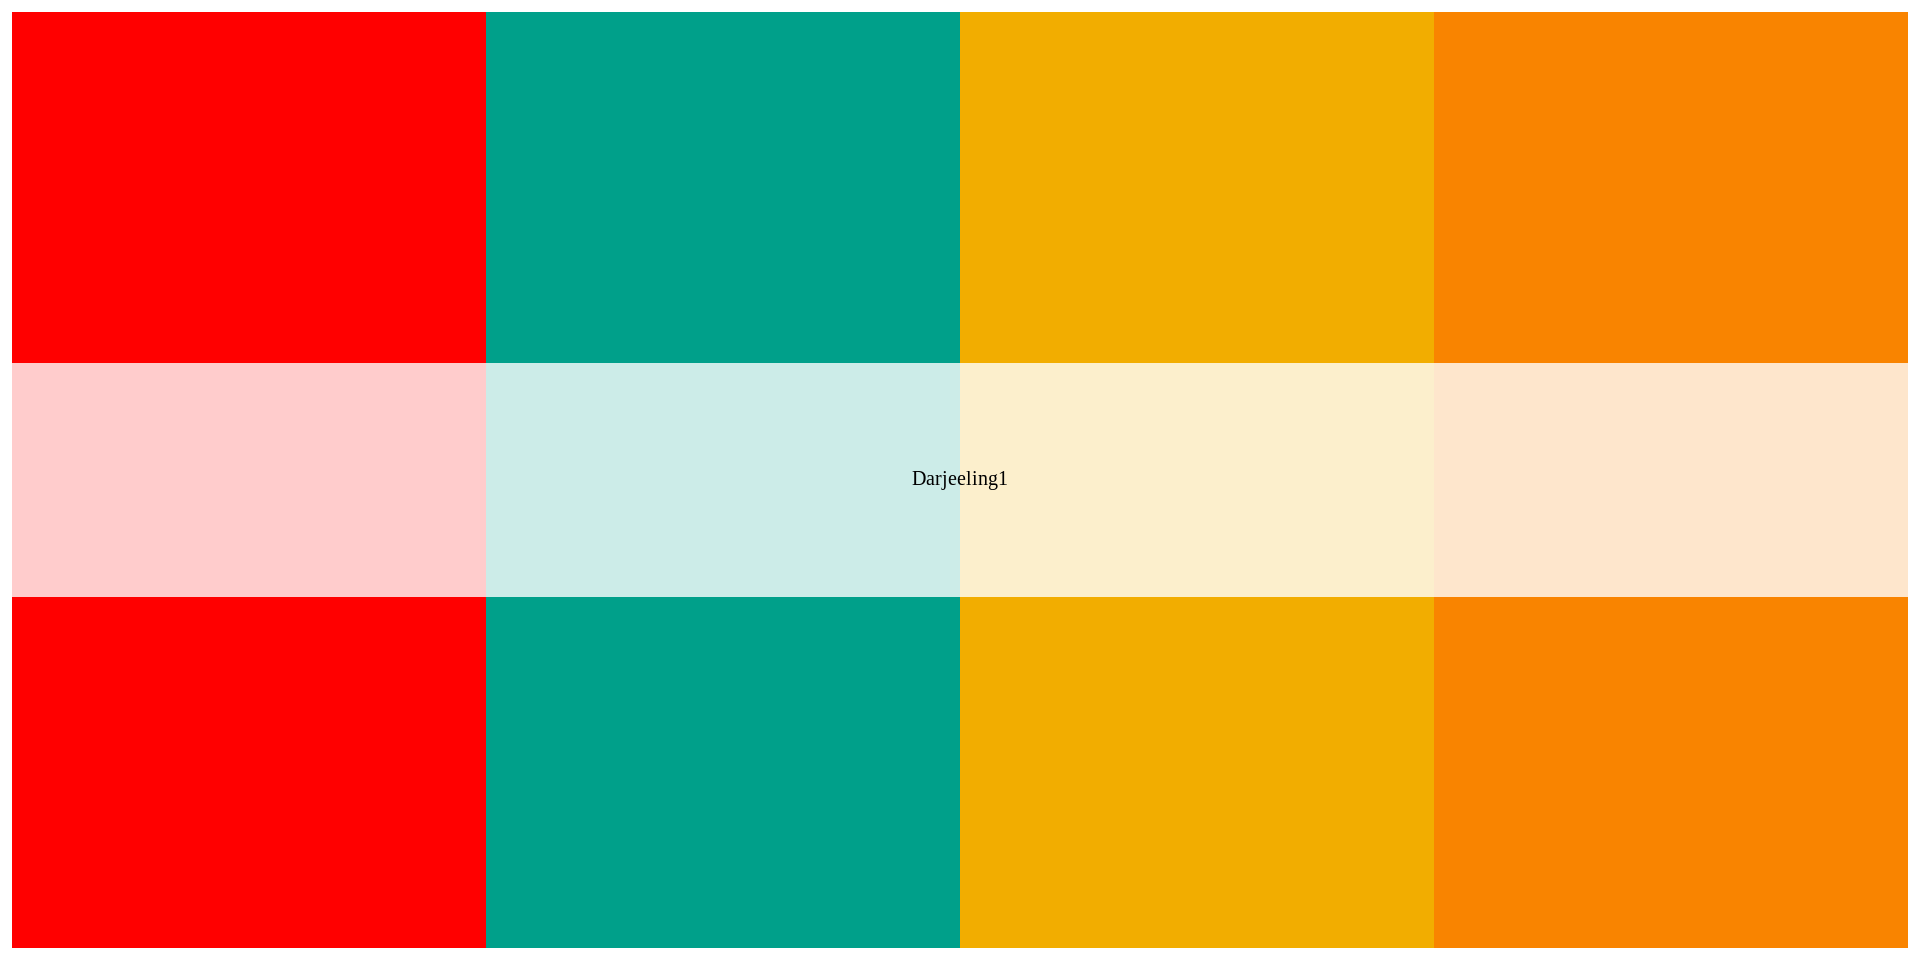

In [9]:
#define a color palette linked to the pattern names so that when we remove constitutive genes from plots all 
#the colors don't shift
patternColors <-
  setNames(wes_palette("Darjeeling1", n = 4), 
           c("Fixed", "Evolved", "Conserved", "Constitutive"))
patternColors
unique(WGCNA_data$Pattern)


# Graph totals by Patterns

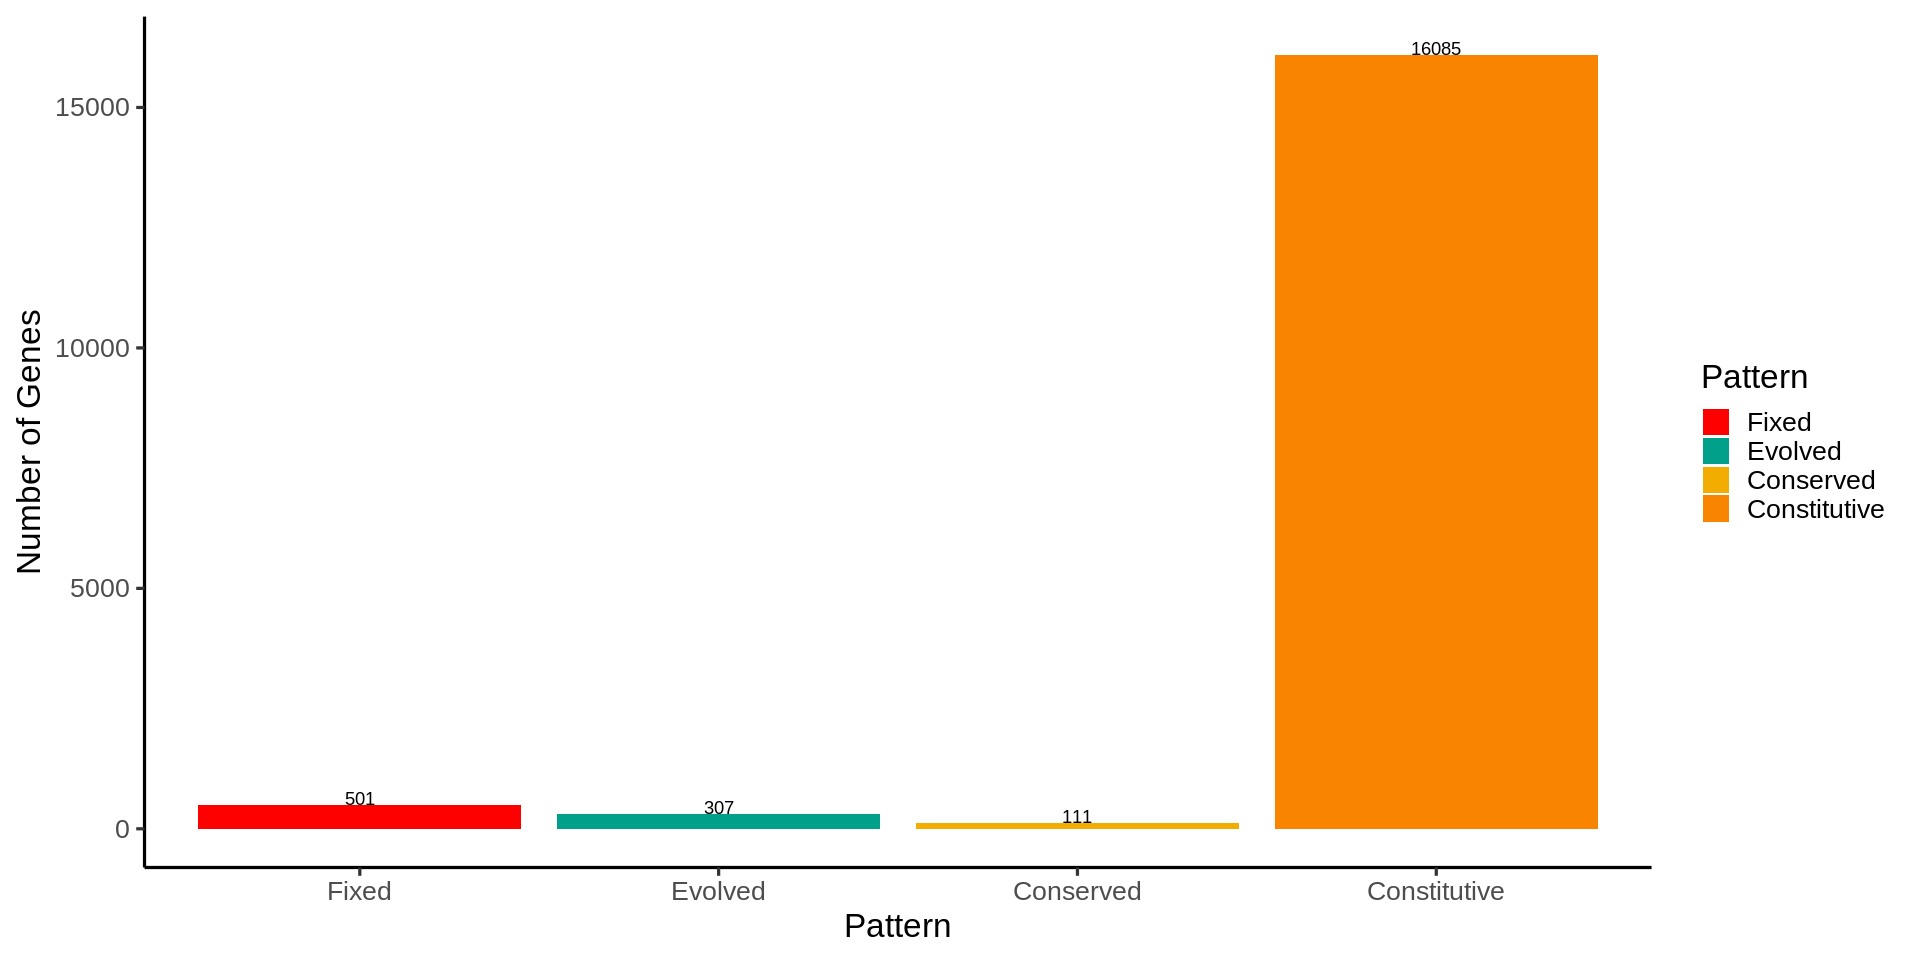

In [10]:
WGCNA_data$Pattern <- factor(WGCNA_data$Pattern, levels = c("Fixed", "Evolved", "Conserved", "Constitutive"))
WGCNA_data %>%
    group_by(Pattern) %>%
    summarize(sum = sum(Counts)) %>%
    data.frame() %>%
    #filter(Pattern!= "Constitutive")%>%
    ggplot(data= . , aes(x=Pattern, y=sum, fill = Pattern))+
        theme_classic(base_size = 20)+
        geom_bar(stat="identity", position=position_dodge())+
        scale_fill_manual(values = patternColors)+
        geom_text(vjust = 0, position = position_dodge(0.9), aes(label = sum)) +
        ylab("Number of Genes")

# Plots with All WGCNA color groups

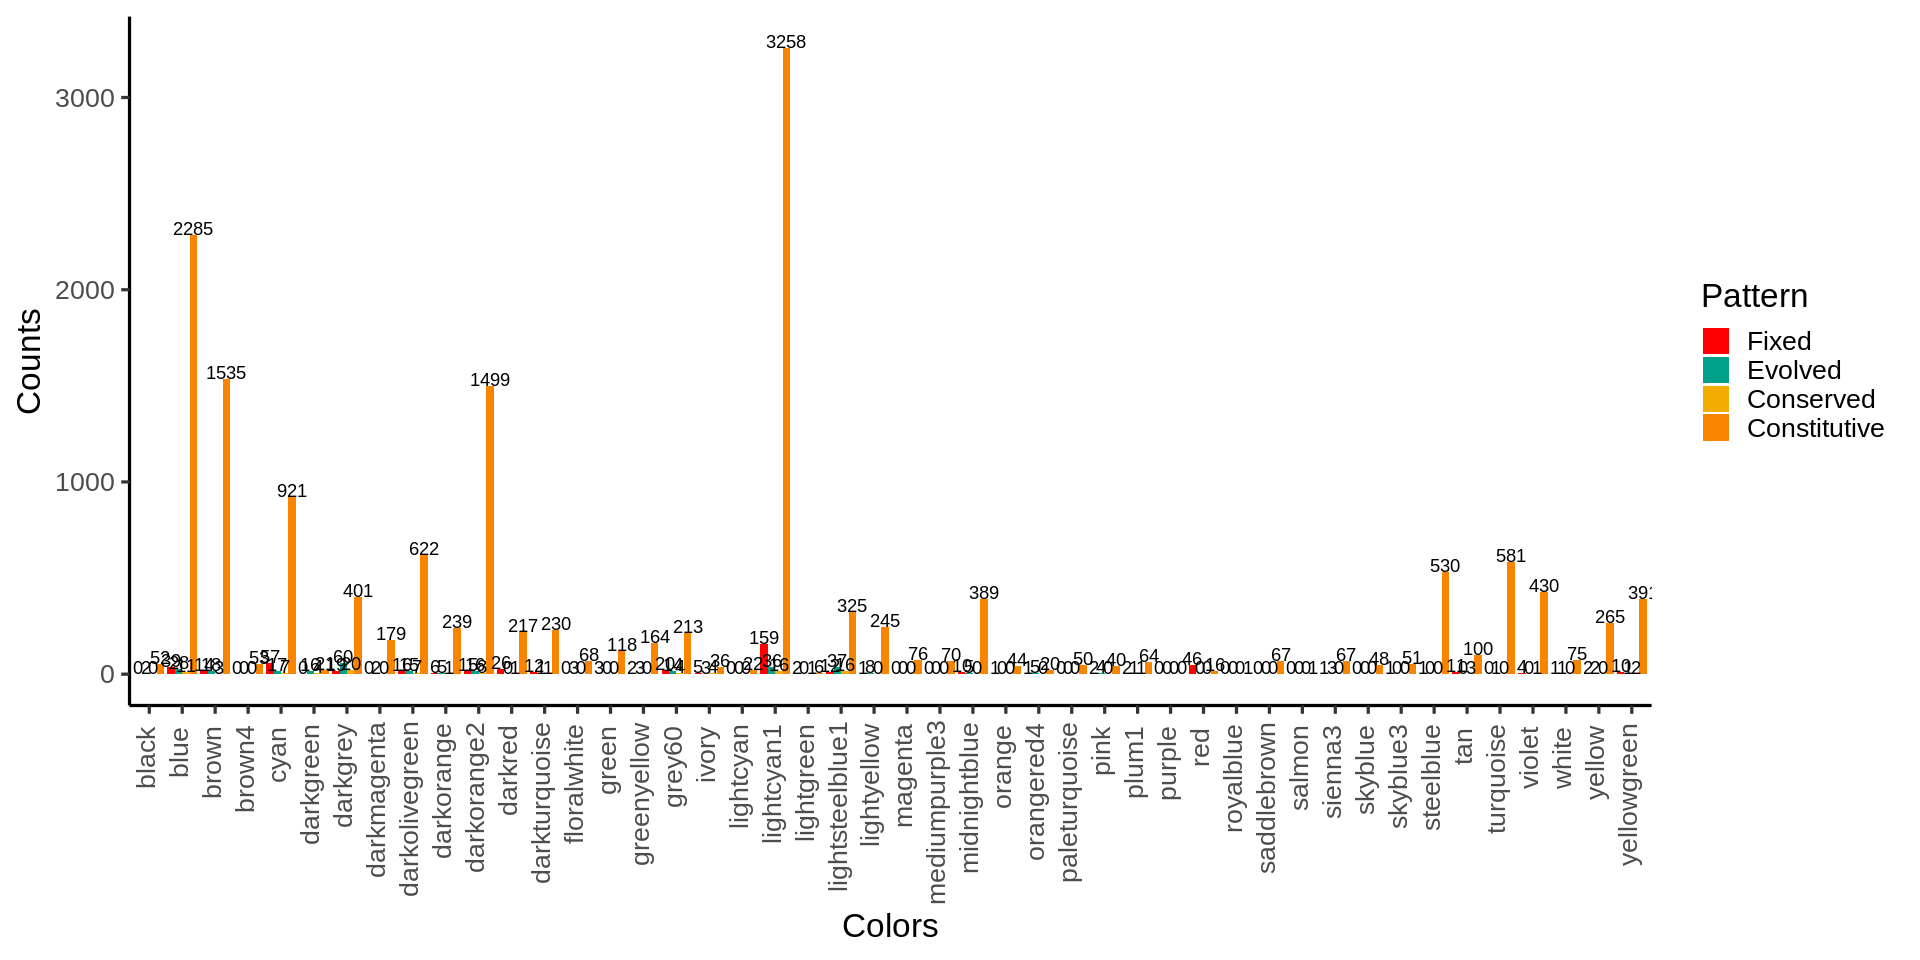

In [11]:
pattern_color_plot <- ggplot(data= WGCNA_data, aes(x=Colors, y=Counts, fill=Pattern))+
    geom_bar(stat="identity", position=position_dodge())+
    theme_classic(base_size = 20)+
    scale_fill_manual(values = patternColors)+
    geom_text(vjust = 0, position = position_dodge(0.9), aes(label = Counts))+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.3, hjust = 0.95))
pattern_color_plot

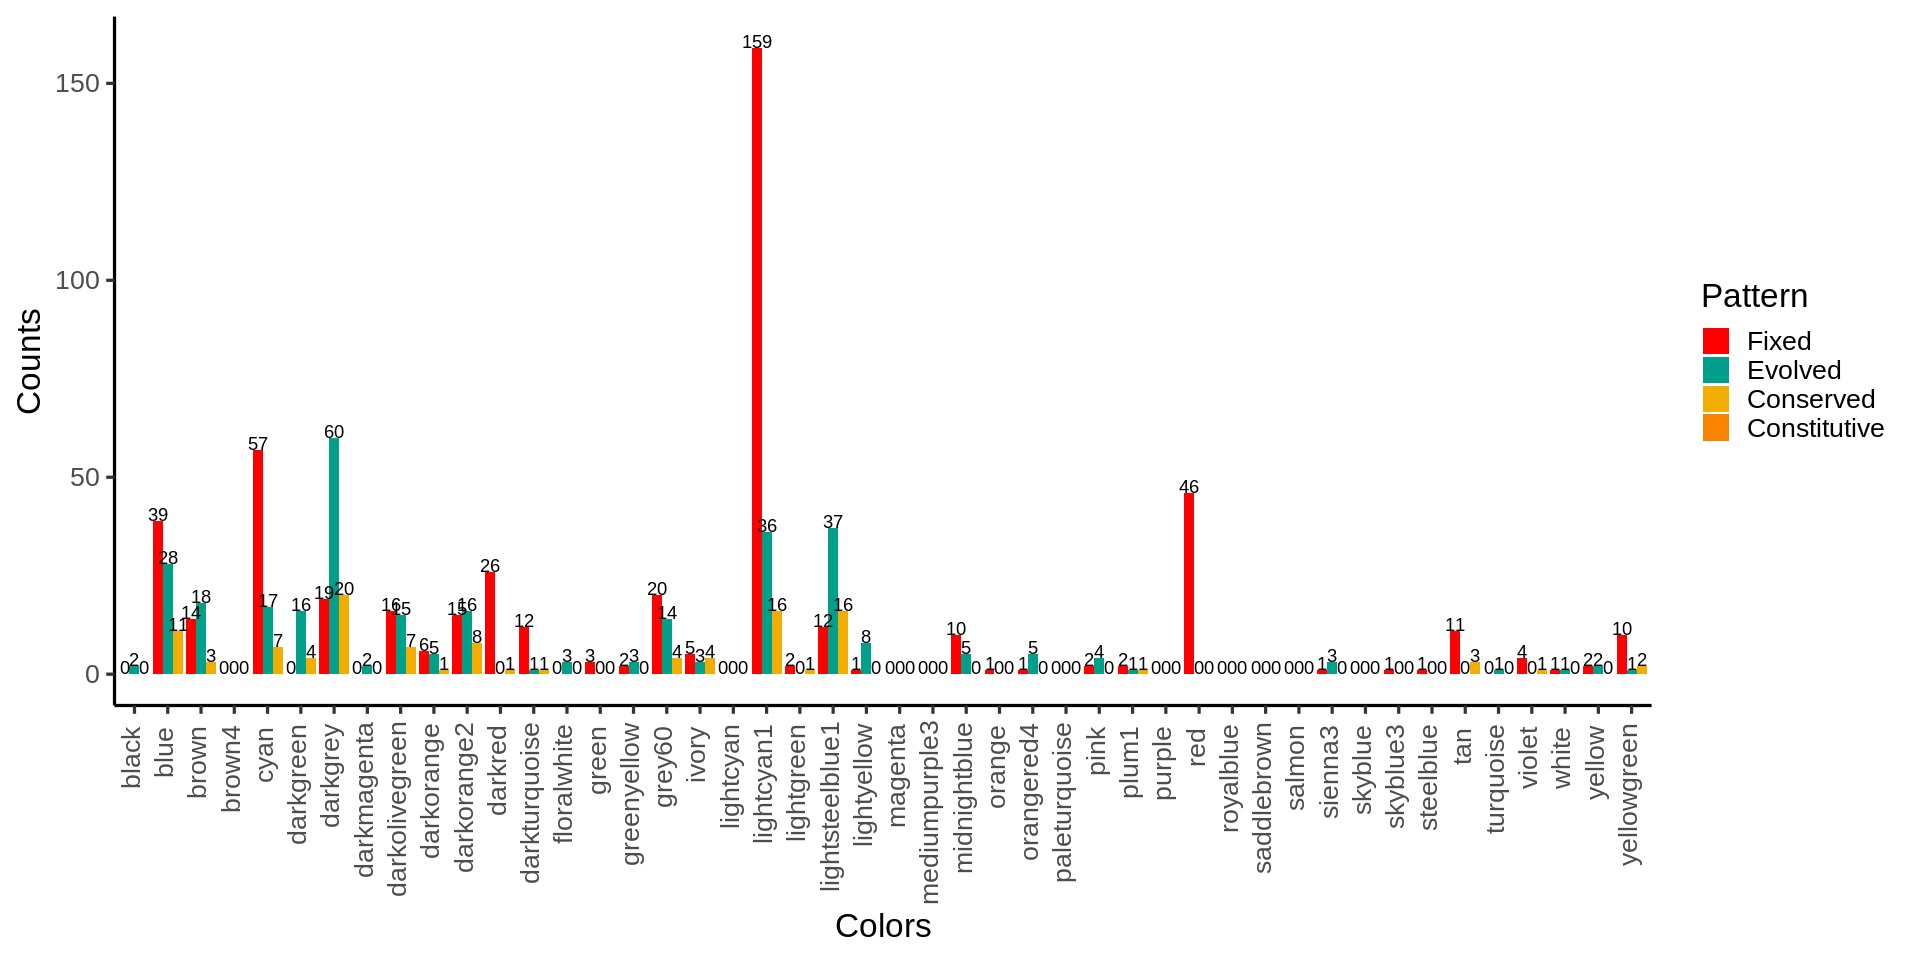

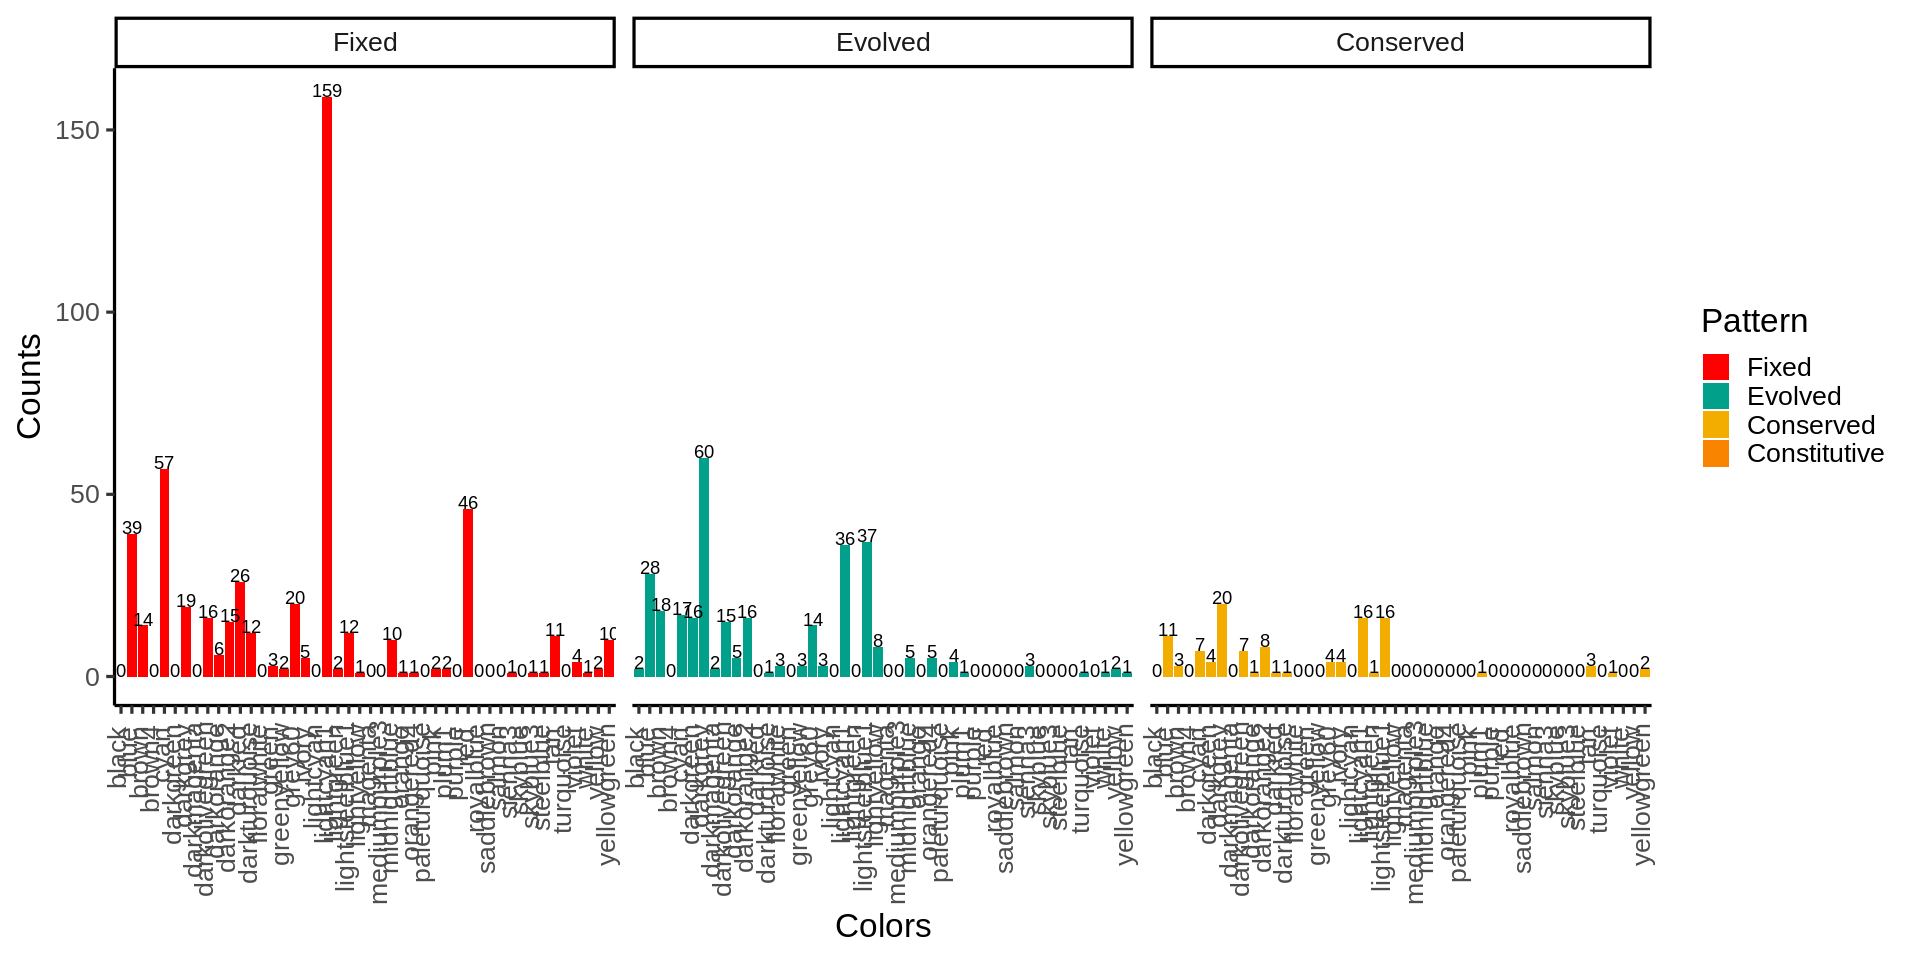

In [12]:
pattern_color_plot <- ggplot(data= WGCNA_data[WGCNA_data$Pattern!= "Constitutive",] , aes(x=Colors, y=Counts, fill=Pattern))+
    geom_bar(stat="identity", position=position_dodge())+
    theme_classic(base_size = 20)+
    scale_fill_manual(values = patternColors)+
    geom_text(vjust = 0, position = position_dodge(0.9), aes(label = Counts))+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.3, hjust = 0.95))
pattern_color_plot

pattern_color_plot + facet_grid(.~ Pattern)

# Filtered Color groups

In [13]:
#filter the color groups to include only those with an average count (not including the consisitutive group) that is >10
filtered_colors <- WGCNA_data %>%
    filter(Pattern!= "Constitutive") %>%
    group_by(Colors) %>%
    summarize(avg = mean(Counts)) %>%
    filter(avg >= 10) %>%
    .$Colors

filtered_colors

[1] "blue"            "brown"           "cyan"            "darkgrey"       
 [5] "darkolivegreen"  "darkorange2"     "grey60"          "lightcyan1"     
 [9] "lightsteelblue1" "red"

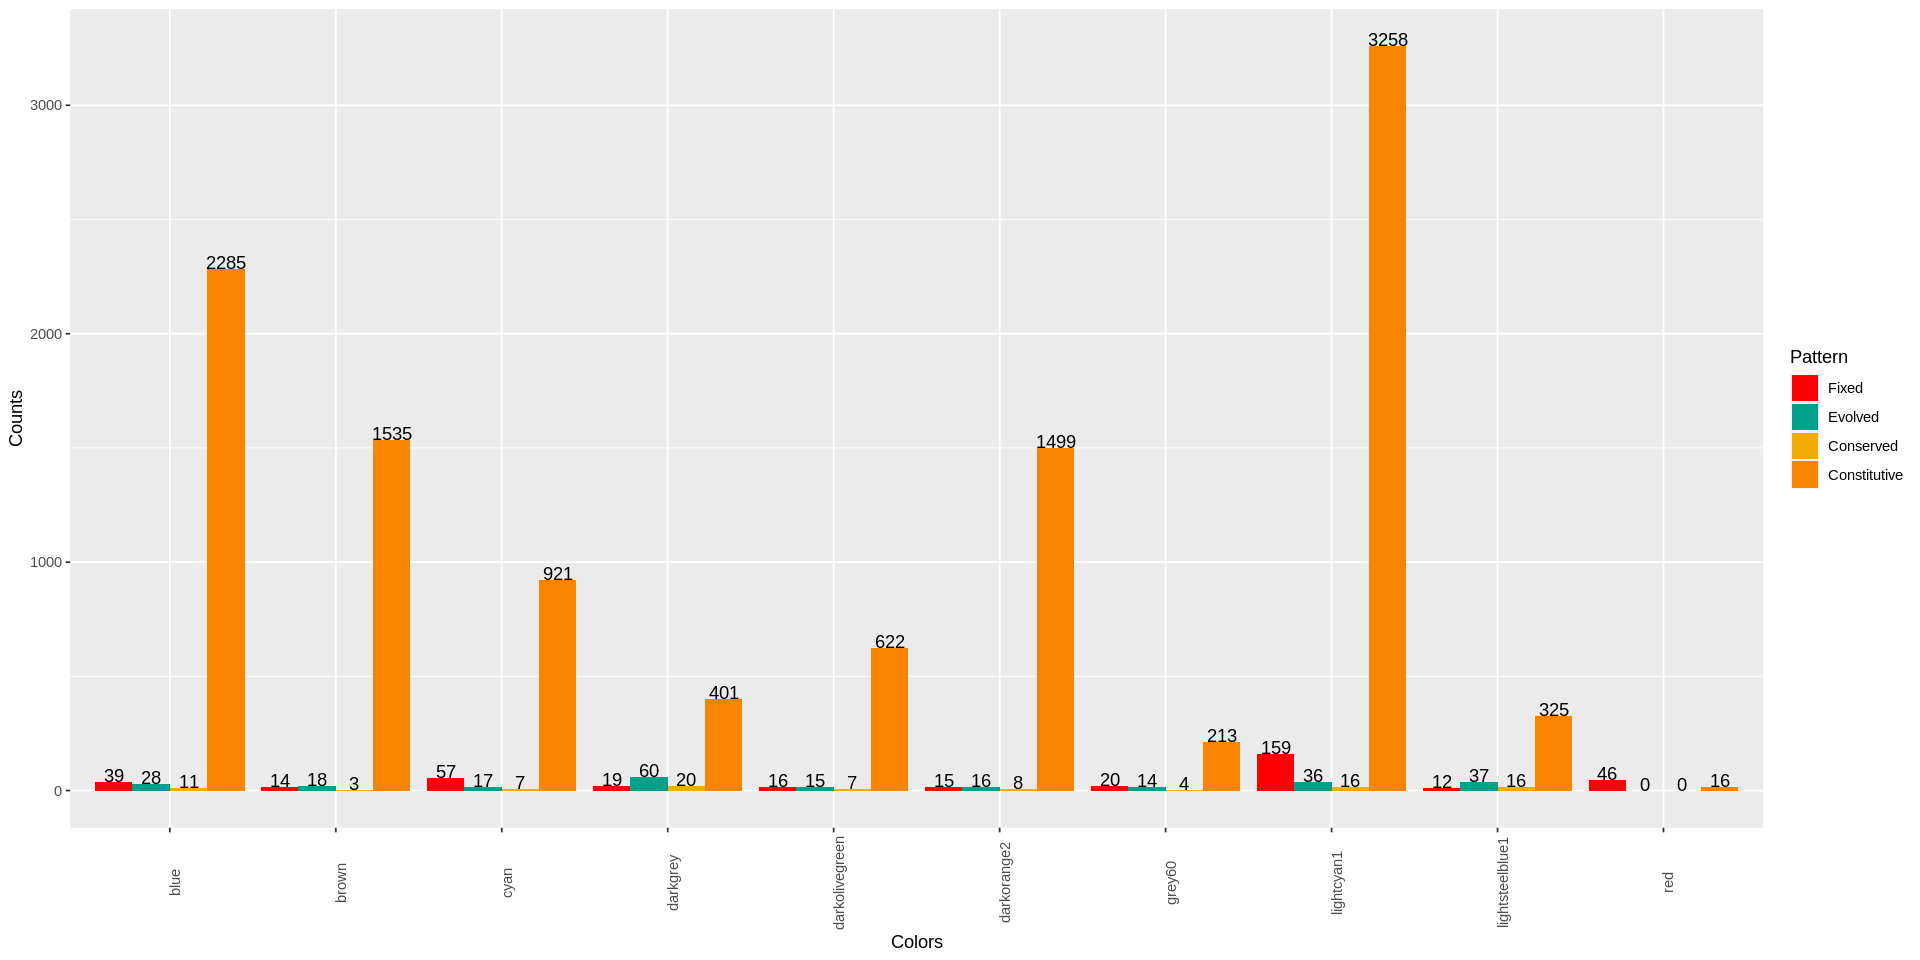

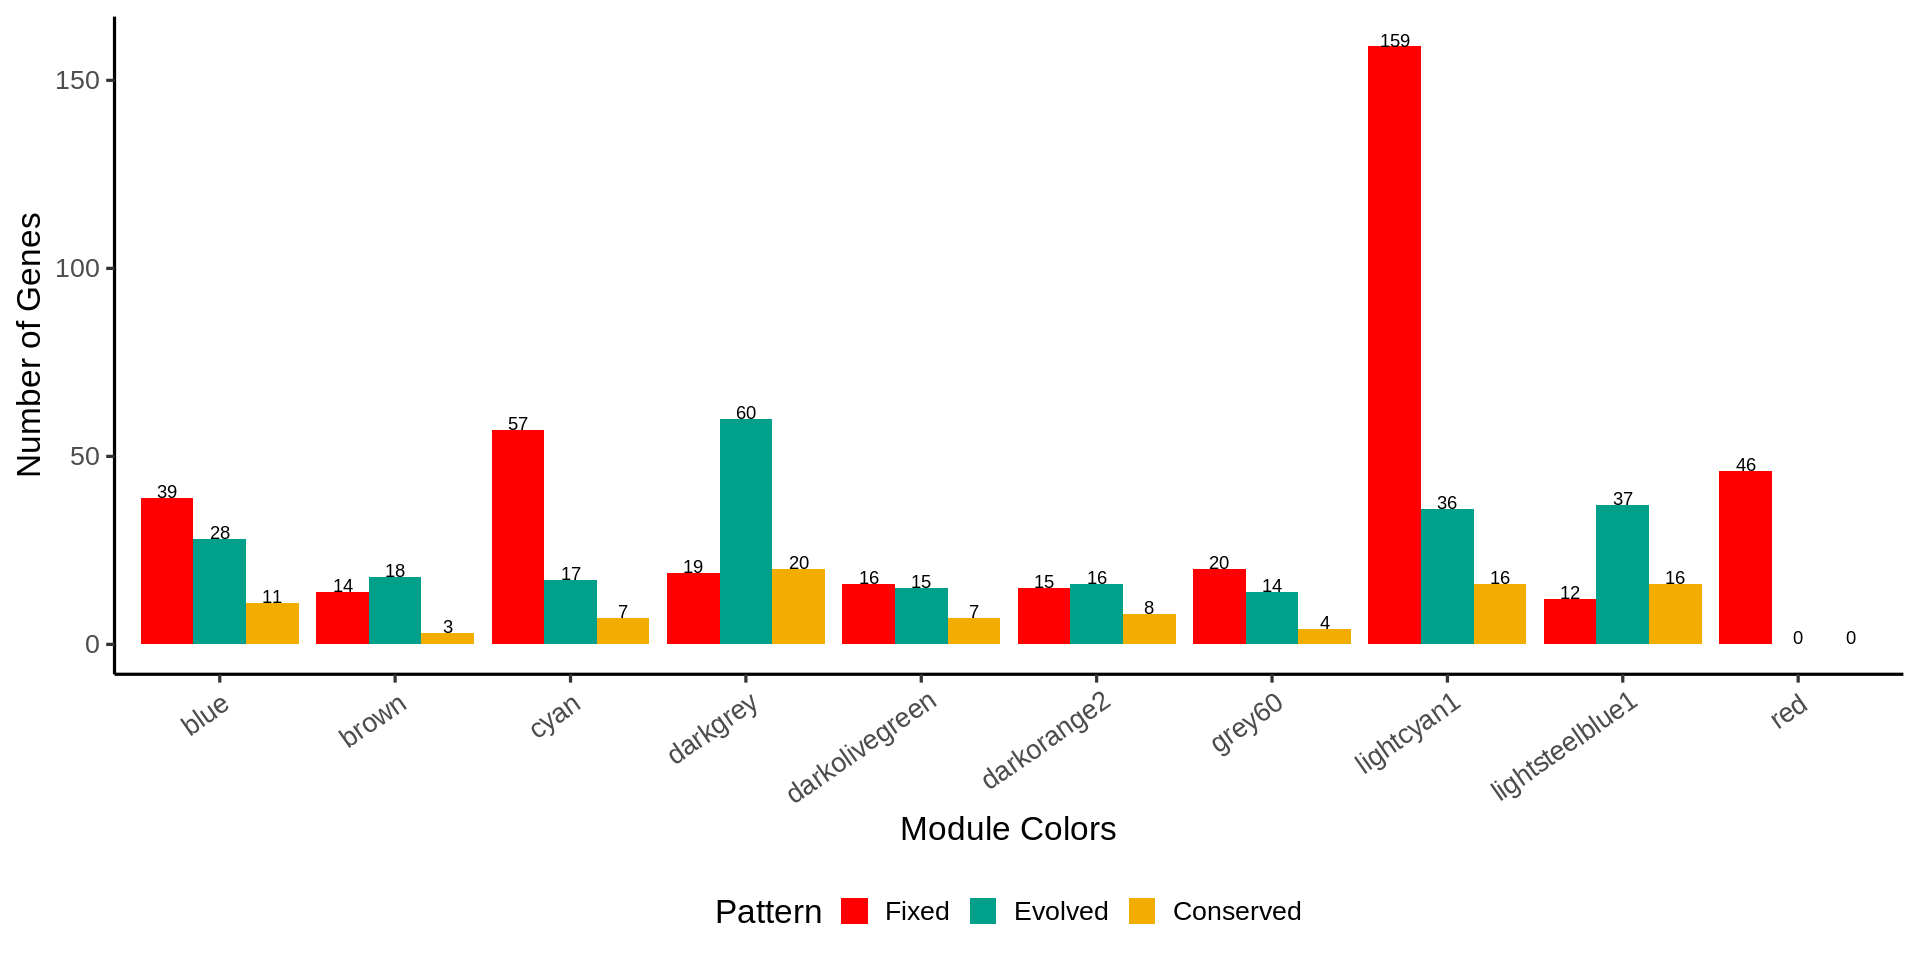

In [14]:
ggplot(data= WGCNA_data[(WGCNA_data$Colors %in% filtered_colors),] , aes(x=Colors, y=Counts, fill=Pattern))+
    geom_bar(stat="identity", position=position_dodge())+
    scale_fill_manual(values = patternColors)+
    geom_text(vjust = 0, position = position_dodge(0.9), aes(label = Counts))+
    theme(axis.text.x = element_text(angle = 90))

ggplot(data= WGCNA_data[(WGCNA_data$Colors %in% filtered_colors) & (WGCNA_data$Pattern!= "Constitutive"),] , aes(x=Colors, y=Counts, fill=Pattern))+
    theme_classic(base_size = 20)+
    geom_bar(stat="identity", position=position_dodge())+
    scale_fill_manual(values = patternColors[-4])+
    geom_text(vjust = 0, position = position_dodge(0.9), aes(label = Counts))+
    theme(axis.text.x = element_text(angle = 35, hjust = 0.95, vjust = 0.95)) +
    xlab("Module Colors") +
    ylab("Number of Genes") +
    theme(legend.position="bottom")

# Wilcox Tests with Pattern Means

In [15]:
#Which groups are statistically significantly different?
#Per pattern, what is the average number of genes?
pattern_means <- WGCNA_data %>%
    group_by(Pattern) %>%
    summarize(avg = mean(Counts), n = n()) %>%
    data.frame()
pattern_means

Pattern,avg,n
<fct>,<dbl>,<int>
Fixed,10.891304,46
Evolved,6.673913,46
Conserved,2.413043,46
Constitutive,349.673913,46


In [16]:
filtered_color_patterns <- WGCNA_data[(WGCNA_data$Colors %in% filtered_colors),]
#filtered_color_patterns
filtered_color_patterns_wide <- dcast(filtered_color_patterns, Colors ~ Pattern)
filtered_color_patterns_wide$pvals <- 0
filtered_color_patterns_wide

Using Counts as value column: use value.var to override.



Colors,Fixed,Evolved,Conserved,Constitutive,pvals
<chr>,<int>,<int>,<int>,<int>,<dbl>
blue,39,28,11,2285,0
brown,14,18,3,1535,0
cyan,57,17,7,921,0
darkgrey,19,60,20,401,0
darkolivegreen,16,15,7,622,0
darkorange2,15,16,8,1499,0
grey60,20,14,4,213,0
lightcyan1,159,36,16,3258,0
lightsteelblue1,12,37,16,325,0


In [17]:
for (row in 1:nrow(filtered_color_patterns_wide)){
    color_data <- as.numeric(filtered_color_patterns_wide[row, c(2:5)])
    filtered_color_patterns_wide[row, 6] <- wilcox.test(color_data, pattern_means$avg)$p.value
}
filtered_color_patterns_wide

Warning message in wilcox.test.default(color_data, pattern_means$avg):
“cannot compute exact p-value with ties”


Colors,Fixed,Evolved,Conserved,Constitutive,pvals
<chr>,<int>,<int>,<int>,<int>,<dbl>
blue,39,28,11,2285,0.2000000
brown,14,18,3,1535,0.4857143
cyan,57,17,7,921,0.3428571
darkgrey,19,60,20,401,0.2000000
darkolivegreen,16,15,7,622,0.3428571
darkorange2,15,16,8,1499,0.3428571
grey60,20,14,4,213,0.6857143
lightcyan1,159,36,16,3258,0.2000000
lightsteelblue1,12,37,16,325,0.3428571


# Chi2 Test

## Filtered Colors

In [18]:
head(filtered_color_patterns_wide)

,Colors,Fixed,Evolved,Conserved,Constitutive,pvals
,<chr>,<int>,<int>,<int>,<int>,<dbl>
1,blue,39,28,11,2285,0.2000000
2,brown,14,18,3,1535,0.4857143
3,cyan,57,17,7,921,0.3428571
4,darkgrey,19,60,20,401,0.2000000
5,darkolivegreen,16,15,7,622,0.3428571
6,darkorange2,15,16,8,1499,0.3428571


In [19]:
#Remake the wide dataframe with the empty p-values column 
filtered_color_patterns_chi2 <- filtered_color_patterns_wide[1:5]
filtered_color_patterns_chi2$pvals <- 0
head(filtered_color_patterns_chi2)

,Colors,Fixed,Evolved,Conserved,Constitutive,pvals
,<chr>,<int>,<int>,<int>,<int>,<dbl>
1,blue,39,28,11,2285,0
2,brown,14,18,3,1535,0
3,cyan,57,17,7,921,0
4,darkgrey,19,60,20,401,0
5,darkolivegreen,16,15,7,622,0
6,darkorange2,15,16,8,1499,0


In [20]:
pattern_counts <- WGCNA_data %>%
    group_by(Pattern) %>%
    summarize(total = sum(Counts)) %>%
    data.frame() %>%
    mutate(proportion = round(total/sum(total), 3))
pattern_counts
sum(pattern_counts$proportion)

Pattern,total,proportion
<fct>,<int>,<dbl>
Fixed,501,0.029
Evolved,307,0.018
Conserved,111,0.007
Constitutive,16085,0.946


[1] 1

In [21]:
for (row in 1:nrow(filtered_color_patterns_chi2)){
    #Get their expected counts from the pattern_means$proportion
    color_data <- as.numeric(filtered_color_patterns_chi2[row, c(2:5)])
    chitest <- chisq.test(color_data, p = pattern_counts$proportion, simulate.p.value = T)
    if (min(chitest$expected) < 5) {
        print("Oh no")
        print(color_data)
        print(chitest$expected)
    }
    filtered_color_patterns_chi2$pvals[row] <- chitest$p.value
}

filtered_color_patterns_chi2

[1] "Oh no"
[1]  19  60  20 401
[1]  14.5   9.0   3.5 473.0
[1] "Oh no"
[1]  16  15   7 622
[1]  19.14  11.88   4.62 624.36
[1] "Oh no"
[1]  20  14   4 213
[1]   7.279   4.518   1.757 237.446
[1] "Oh no"
[1]  12  37  16 325
[1]  11.31   7.02   2.73 368.94
[1] "Oh no"
[1] 46  0  0 16
[1]  1.798  1.116  0.434 58.652


Colors,Fixed,Evolved,Conserved,Constitutive,pvals
<chr>,<int>,<int>,<int>,<int>,<dbl>
blue,39,28,11,2285,0.0004997501
brown,14,18,3,1535,0.0004997501
cyan,57,17,7,921,0.0004997501
darkgrey,19,60,20,401,0.0004997501
darkolivegreen,16,15,7,622,0.4717641179
darkorange2,15,16,8,1499,0.0004997501
grey60,20,14,4,213,0.0004997501
lightcyan1,159,36,16,3258,0.0004997501
lightsteelblue1,12,37,16,325,0.0004997501


## Whole dataframe

In [22]:
head(WGCNA_data)
WGCNA_data_wide <- dcast(WGCNA_data, Colors ~ Pattern)
WGCNA_data_wide$pvals <- 0
WGCNA_data_wide[is.na(WGCNA_data_wide)] <- 0
dim(WGCNA_data_wide)
head(WGCNA_data_wide)

Colors,Pattern,Counts
<chr>,<fct>,<int>
lightcyan1,Constitutive,3258
blue,Constitutive,2285
brown,Constitutive,1535
darkorange2,Constitutive,1499
cyan,Constitutive,921
darkolivegreen,Constitutive,622


Using Counts as value column: use value.var to override.



[1] 46  6

,Colors,Fixed,Evolved,Conserved,Constitutive,pvals
,<chr>,<int>,<int>,<int>,<int>,<dbl>
1,black,0,2,0,52,0
2,blue,39,28,11,2285,0
3,brown,14,18,3,1535,0
4,brown4,0,0,0,53,0
5,cyan,57,17,7,921,0
6,darkgreen,0,16,4,21,0


In [23]:
#Purple has no genes in it :/
module_genes[module_genes$colors == "purple","genes"]
df[df$Colors == "purple",]

[1] "ChreCt024, Cre06.g271750, Cre08.g383000, Cre13.g606956, g10760, g14076, g14361, g15333, g1539, g15919, g17148, g3723, g54, g5445, g6757, g704, g7663, g8166, g8183, g8665, g9215"

,Genes,Colors,Conserved,Constitutive,Fixed,Evolved
,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
13631,ChreCt024,purple,FALSE,FALSE,FALSE,FALSE
13632,Cre06.g271750,purple,FALSE,FALSE,FALSE,FALSE
13633,Cre08.g383000,purple,FALSE,FALSE,FALSE,FALSE
13634,Cre13.g606956,purple,FALSE,FALSE,FALSE,FALSE
13635,g10760,purple,FALSE,FALSE,FALSE,FALSE
13636,g14076,purple,FALSE,FALSE,FALSE,FALSE
13637,g14361,purple,FALSE,FALSE,FALSE,FALSE
13638,g15333,purple,FALSE,FALSE,FALSE,FALSE
13639,g1539,purple,FALSE,FALSE,FALSE,FALSE


In [24]:
WGCNA_data_wide[2:5] <- WGCNA_data_wide[2:5] + 1
head(WGCNA_data_wide)

,Colors,Fixed,Evolved,Conserved,Constitutive,pvals
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,black,1,3,1,53,0
2,blue,40,29,12,2286,0
3,brown,15,19,4,1536,0
4,brown4,1,1,1,54,0
5,cyan,58,18,8,922,0
6,darkgreen,1,17,5,22,0


In [25]:
for (row in 1:nrow(WGCNA_data_wide)){
    #Get their expected counts from the pattern_means$proportion
    color_data <- as.numeric(WGCNA_data_wide[row, c(2:5)])
    chitest <- chisq.test(c(color_data), p = (pattern_counts$proportion), simulate.p.value = T)
    WGCNA_data_wide$pvals[row] <- chitest$p.value
}
WGCNA_data_wide[2:5] <- WGCNA_data_wide[2:5] - 1
(WGCNA_data_wide)
dim(WGCNA_data_wide)

Colors,Fixed,Evolved,Conserved,Constitutive,pvals
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
black,0,2,0,52,0.1469265367
blue,39,28,11,2285,0.0004997501
brown,14,18,3,1535,0.0004997501
brown4,0,0,0,53,0.8160919540
cyan,57,17,7,921,0.0004997501
darkgreen,0,16,4,21,0.0004997501
darkgrey,19,60,20,401,0.0004997501
darkmagenta,0,2,0,179,0.2598700650
darkolivegreen,16,15,7,622,0.2533733133


[1] 46  6

In [26]:
dim(WGCNA_data_wide[WGCNA_data_wide$pvals > 0.05,])
dim(WGCNA_data_wide[WGCNA_data_wide$pvals <= 0.05,])
dim(WGCNA_data_wide[WGCNA_data_wide$pvals <= 0.01,])
dim(WGCNA_data_wide)

[1] 23  6

[1] 23  6

[1] 21  6

[1] 46  6

In [27]:
rownames(pattern_counts) <- pattern_counts$Pattern
pattern_counts["Constitutive","proportion"]

[1] 0.946

,Colors,Fixed,Evolved,Conserved,Constitutive,pvals
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
blue,blue,39,28,11,2285,0.0004997501
brown,brown,14,18,3,1535,0.0004997501
cyan,cyan,57,17,7,921,0.0004997501
darkgreen,darkgreen,0,16,4,21,0.0004997501
darkgrey,darkgrey,19,60,20,401,0.0004997501
darkorange2,darkorange2,15,16,8,1499,0.0004997501


,Pattern,total,proportion
,<fct>,<int>,<dbl>
Fixed,Fixed,501,0.029
Evolved,Evolved,307,0.018
Conserved,Conserved,111,0.007
Constitutive,Constitutive,16085,0.946


,Colors,variable,value
,<chr>,<fct>,<dbl>
1,blue,Fixed,0.5691187
2,brown,Fixed,0.3074896
3,cyan,Fixed,1.9615941
4,darkgreen,Fixed,0.0000000
5,darkgrey,Fixed,1.3103448
6,darkorange2,Fixed,0.3363078


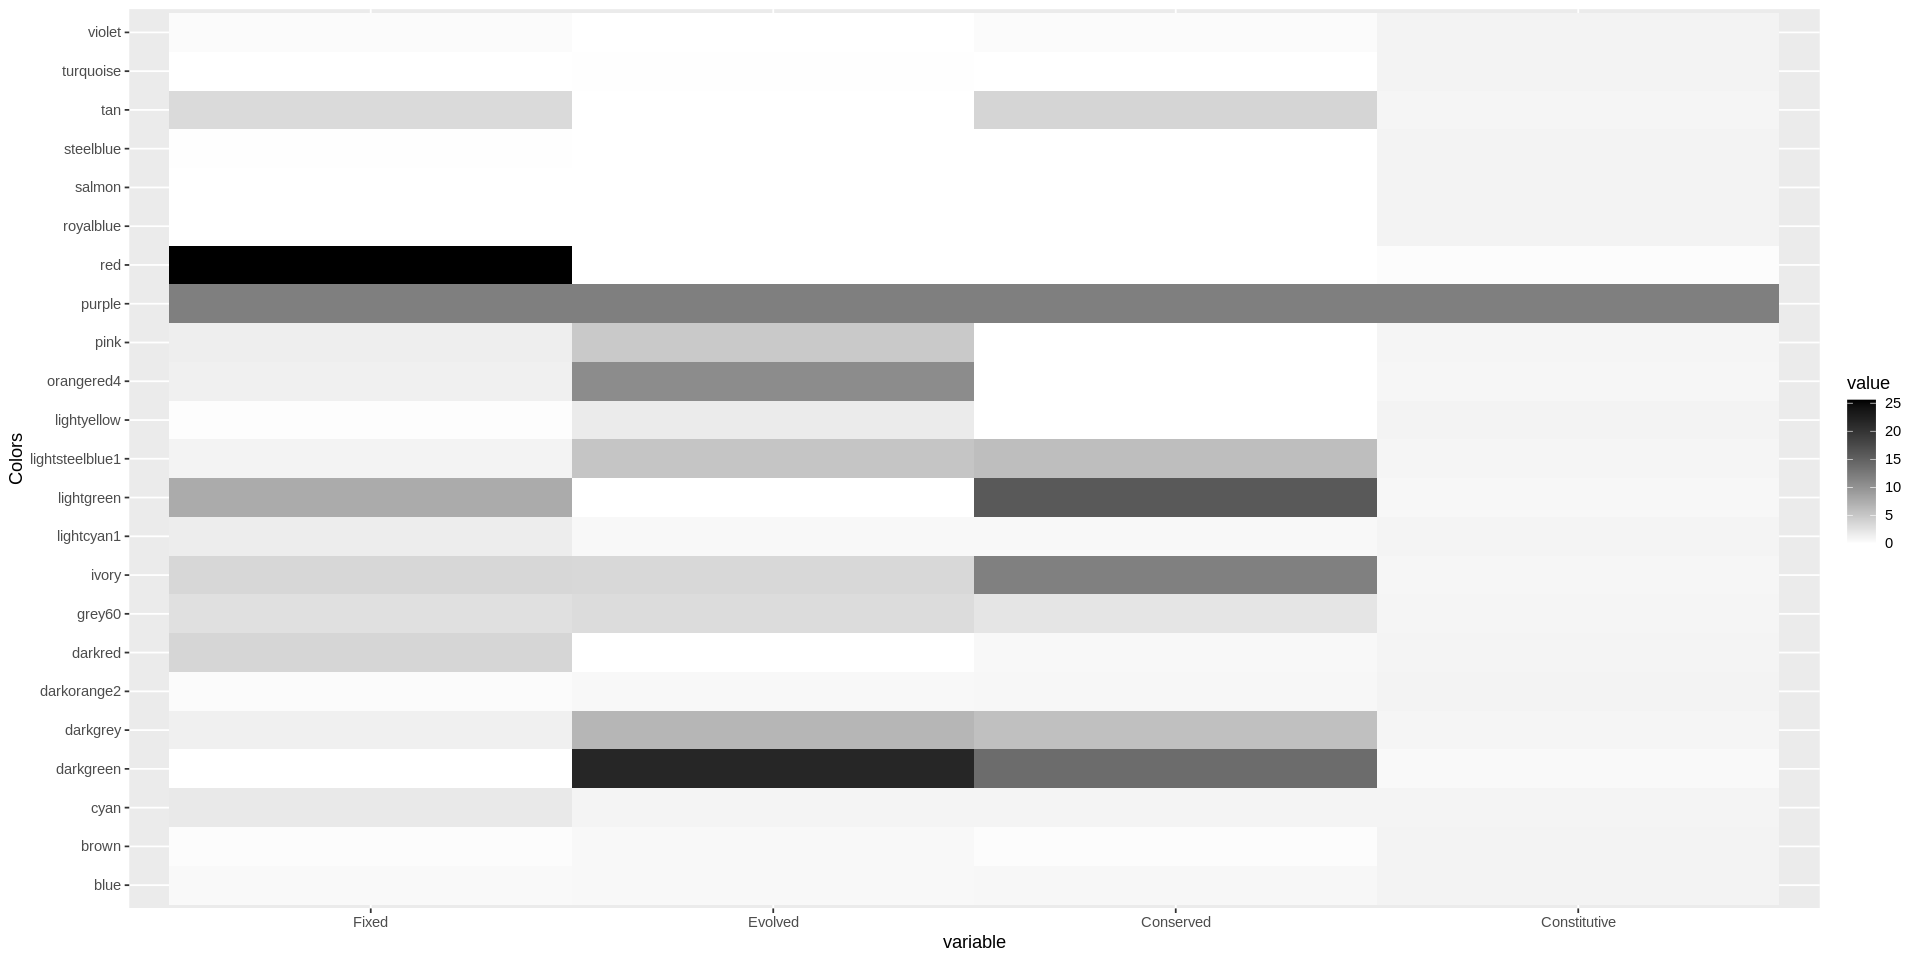

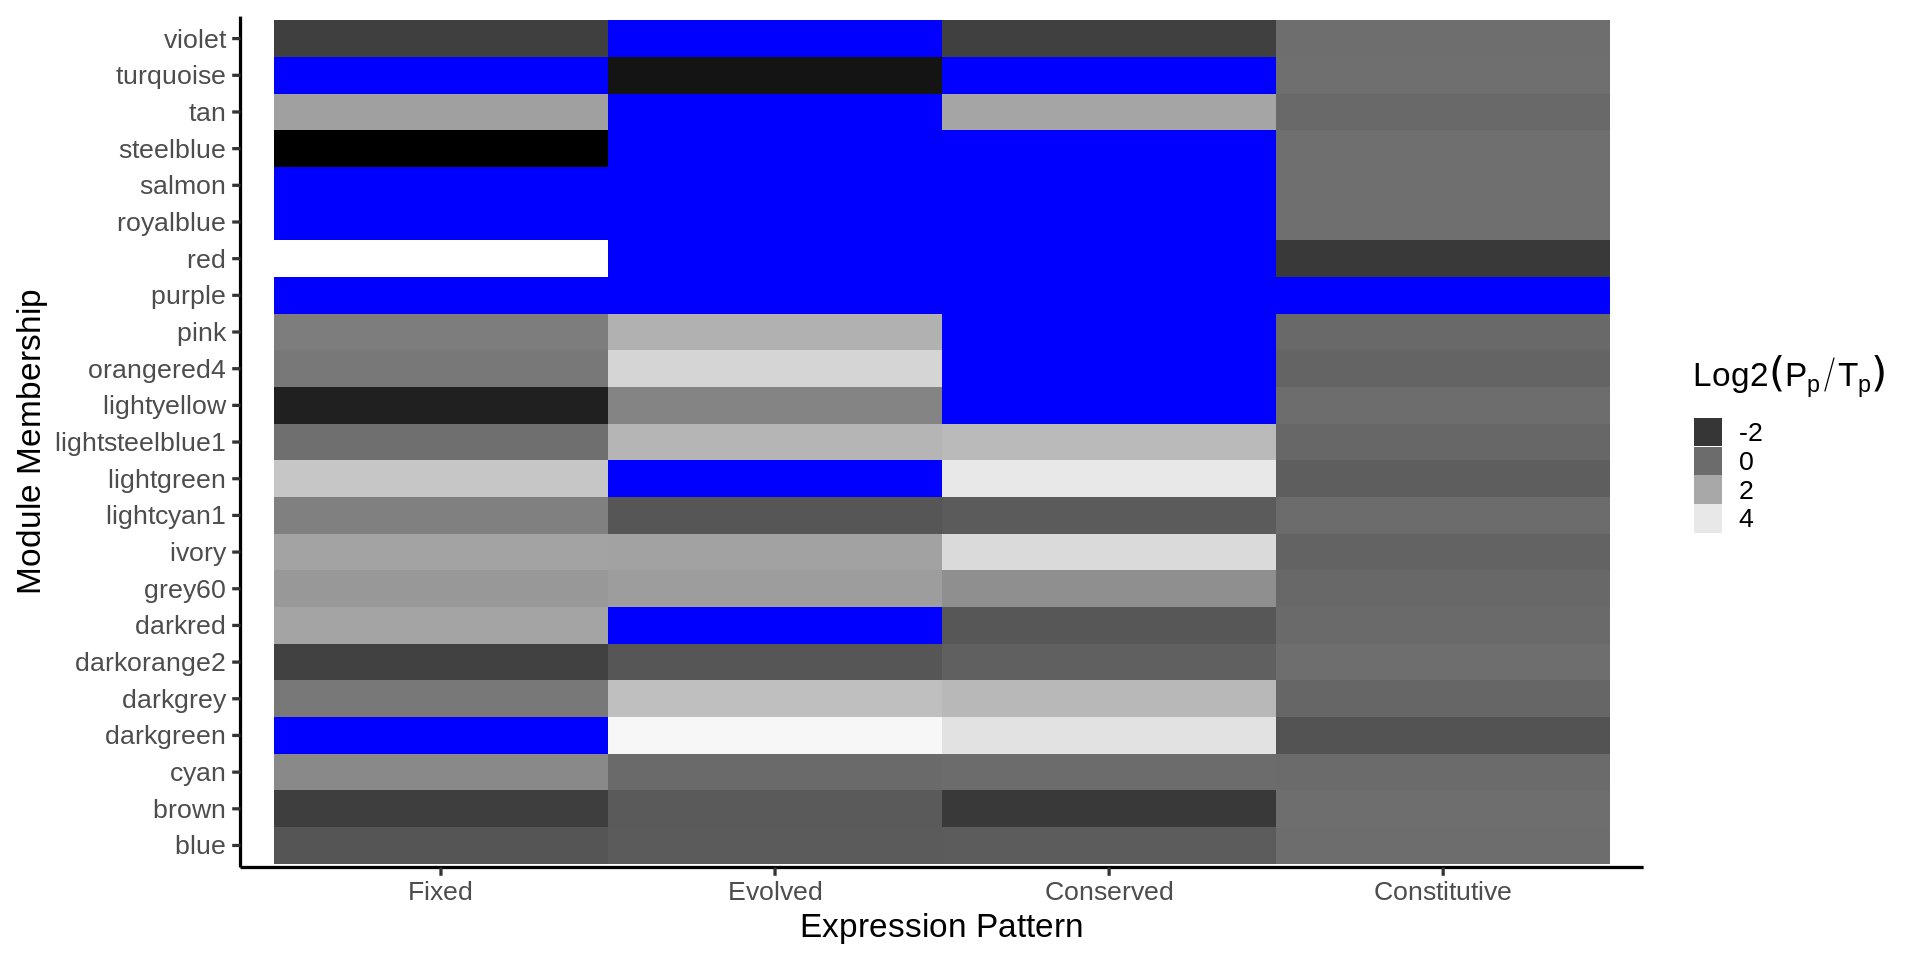

In [28]:
sig_genes <- WGCNA_data_wide[WGCNA_data_wide$pvals <= 0.05,]
rownames(sig_genes) <- sig_genes$Colors
head(sig_genes)
pattern_counts
sig_genes <- sig_genes %>% 
#     rowwise() %>%
    select(Fixed:Constitutive) %>%
    mutate(total = rowSums(.)) %>% 
    mutate(Constitutive = Constitutive/total/pattern_counts["Constitutive","proportion"]) %>% 
    mutate(Conserved = Conserved/total/pattern_counts["Conserved","proportion"])%>% 
    mutate(Fixed = Fixed/total/pattern_counts["Fixed","proportion"]) %>% 
    mutate(Evolved = Evolved/total/pattern_counts["Evolved","proportion"]) %>%
    mutate(Colors = rownames(.)) %>%
    select(c(Fixed:Constitutive), Colors) %>%
    melt(data = ., id.vars = "Colors") 
head(sig_genes)

ggplot(data = sig_genes, aes(y = Colors, x = variable, fill = value)) + 
    geom_tile() + 
    scale_fill_gradient(low="white", high="black")

ggplot(data = sig_genes, aes(y = Colors, x = variable, fill = log2(value))) + 
    geom_tile() + 
    theme_classic(base_size = 20)+
    xlab("Expression Pattern") +
    ylab("Module Membership")+
    guides(fill=guide_legend(title=bquote(Log2(P[p]/T[p]))))+
    scale_fill_gradient(low="black", high="white", na.value = "blue")
    
# sig_genes$value <- ifelse(sig_genes$value >= 4, yes = 4, no = sig_genes$value)
# ggplot(data = sig_genes, aes(y = Colors, x = variable, fill = value)) + 
#     geom_tile() + 
#     scale_fill_gradient(low="white", high="blue")